In [23]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
rc = Client()

In [4]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [5]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

In [6]:
def compute_inv_shrunk_covariance(x,mask):
    #see http://www.diedrichsenlab.org/pubs/Walther_Neuroimage_2016.pdf
    t,n = x.shape #t measurements by n voxels

    #demean
    x = x - x.mean(0)

    #compute covariance
    sample = (1.0/t) * np.dot(np.transpose(x),x)

    #copute prior
    prior = np.diag(np.diag(sample))

    #compute shrinkage
    d = 1.0/n * np.linalg.norm(sample - prior,ord = 'fro')**2
    y = np.square(x)
    r2 = 1.0/n/t**2 * np.sum(np.sum(np.dot(np.transpose(y),y)))- \
    1.0/n/t*np.sum(np.sum(np.square(sample)))

    #compute the estimator
    shrinkage = max(0,min(1,r2/d))
    sigma = shrinkage*prior + (1-shrinkage)*sample

    #compute the inverse
    if is_invertible(sigma) or mask != 'VTC_sim':
        inv_sigma = np.linalg.inv(sigma)
    else:
        inv_sigma = np.linalg.inv(prior) #univariate
    
    return inv_sigma

In [7]:
#make sure MTL masks are exclusive
def trim_mask(sub,mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)

    m1 = op.join(home_dir,'data', sub,  'masks', exclusions[0] +'.nii.gz')
    m1 = nib.load(m1).get_data().astype(bool)

    m2 = op.join(home_dir,'data', sub,  'masks', exclusions[1] +'.nii.gz')
    m2 = nib.load(m2).get_data().astype(bool)

    bad = np.logical_or(m1,m1)
    good = np.invert(bad)

    mask = np.logical_and(mask,good)
    return mask

In [8]:
def compute_inverse_sigma(sub,exp,smooth,masks):
    sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth)
    for run in map(str,range(1,4)):
        res = op.join(sub_path, 'run_'  + run,'res4d_xfm.nii.gz')
        
        if op.exists(res):
            res = nib.load(res).get_data().astype(float)

            for m in masks:
                out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
                
                if not op.exists(out_f): #don't recompute
                    mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
                    mask = nib.load(mask).get_data().astype(bool)
                    if m in overlap_masks:
                        mask = trim_mask(sub,mask,m)

                    x = res[mask]
                    x = np.transpose(x)

                    inv_sigma = compute_inv_shrunk_covariance(x,m)

                    inv_sigma = scipy.linalg.fractional_matrix_power(inv_sigma,.5) #take square root

                    np.savetxt(out_f,inv_sigma)

In [9]:
def delete_inverse_sigma(sub,exp,smooth,masks):
    for run in map(str,range(1,4)):
        for m in masks:
            out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
            if op.exists(out_f):
                os.remove(out_f)

In [138]:
def get_condition(i,single):
    if single:
        return cond_map[i], 1
    elif i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [139]:
def extract_betas(sub,exp,smooth,masks,single = True):
    if single:
        nbetas = 4
    else:
        nbetas = 40
        exp_id = 'sim_4mm-betas'
            
    all_betas = []
    for m in masks:
        out_f = op.join(home_dir,'betas', '_'.join([exp_id,smooth,m]) + '.csv')
        
        #extract saved betas
        if not op.exists(out_f):
            betas = {'sub':[],'mask':[],'run':[],'condition':[],'value':[],'trial':[],'voxel':[],'row':[]}
            sub_path = op.join(home_dir,'analysis', exp_id, sub, 'reg','epi', smooth )

            mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
            mask = nib.load(mask).get_data().astype(bool)
            if m in overlap_masks:
                mask = trim_mask(sub,mask,m)


            for run in map(str,range(1,4)):
                run_dir = op.join(sub_path, 'run_'  + run)

                if os.path.exists(run_dir):

                    for i in range(1,nbetas + 1):
                        f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'

                        cond, trial = get_condition(i,single)

                        #load stat image
                        stat = nib.load(f).get_data().astype(float)
                        stat = stat[mask]

                        for n,val in enumerate(stat):
                            betas['voxel'].append(n)                        
                            betas['sub'].append(sub)
                            betas['value'].append(val)
                            betas['mask'].append(m)
                            betas['run'].append(run)
                            betas['condition'].append(cond)
                            betas['trial'].append(trial)
                            betas['row'].append(i)
                else:
                    print run_dir

            betas = pd.DataFrame(betas)
            betas.to_csv(out_f,index = False)
            
        else: #load from disk
            betas = pd.read_csv(out_f)
            
        all_betas.append(betas)

    betas = betas.set_index(['sub', 'run','mask','condition'])
    return betas

In [149]:
def prewhiten_betas(sub,betas,masks):
    out_f = op.join(home_dir,'betas','whitened',sub + '.csv')
    
    if not op.exists(out_f):
        for run in map(str,range(1,4)):
            for m in masks:
                #load covariance
                inv_sigma = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')

                if op.exists(inv_sigma):
                    inv_sigma = np.loadtxt(inv_sigma)

                    for cond in cond_map.values():
                        vals = betas.loc[(sub,run,m,cond),'value'].values
                        whiten_vals = np.dot(vals,inv_sigma)
                        betas.loc[(sub,run,m,cond),'value'] = whiten_vals
        betas.to_csv(out_f,index = False)
    return betas

In [150]:
def compute_rsa(sub,exp,masks,betas):
    rsas = {}
    for m in masks:
        
        runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
        nruns = len(runs)
        rsa = np.zeros((nconds,nconds))

        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                corr = []
                
                corr.append(scipy.stats.pearsonr(betas.loc[(sub,'1',m,cond_map[i]),'value'].values,
                                     betas.loc[(sub,'2',m,cond_map[j]),'value'].values))
                if i != j:
                    corr.append(scipy.stats.pearsonr(betas.loc[(sub,'2',m,cond_map[i]),'value'].values,
                                         betas.loc[(sub,'1',m,cond_map[j]),'value'].values))

                if nruns == 3:

                    corr.append(scipy.stats.pearsonr(betas.loc[(sub,'1',m,cond_map[i]),'value'].values,
                                         betas.loc[(sub,'3',m,cond_map[j]),'value'].values))
                    corr.append(scipy.stats.pearsonr(betas.loc[(sub,'2',m,cond_map[i]),'value'].values,
                                         betas.loc[(sub,'3',m,cond_map[j]),'value'].values))
                    if i != j:
                        corr.append(scipy.stats.pearsonr(betas.loc[(sub,'3',m,cond_map[i]),'value'].values,
                                                         betas.loc[(sub,'1',m,cond_map[j]),'value'].values))
                        corr.append(scipy.stats.pearsonr(betas.loc[(sub,'3',m,cond_map[i]),'value'].values,
                                                         betas.loc[(sub,'2',m,cond_map[j]),'value'].values))
                       
                rsa[i-1,j-1]  = np.nanmean(corr)
        rsas[m] = rsa
        
    return rsas

In [151]:
def compute_rsa_euclid(sub,exp,masks,betas):
    rsas = {}
    for m in ['hipp']:
        
        #Get crossval folds. Deal with unequal number of runs across subjects
        runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index)))
        nruns = len(runs)
        if nruns == 3:
            train_runs = [['1','2'],['1','3'],['2','3']]
        elif nruns == 2:
            train_runs = [['1'],['2']]
        
        rsa = np.zeros((4,4,len(runs)))

        #loop through condition pairs
        for i in range(1,rsa.shape[0]+1):
            for j in range(1,rsa.shape[0]+1):
                if j < i:
                    #get euclidian distance between conditions for each run
                    run_euclid_dist = {}
                    for run in map(str,range(1,nruns+1)):
                        
                        cond1 = betas.loc[(sub,run,m,cond_map[i]),'value'].values
                        cond2 = betas.loc[(sub,run,m,cond_map[j]),'value'].values
                        
                        run_euclid_dist[run] = cond1 - cond2
                    
                    #do cross-validation
                    for n,train_run in enumerate(train_runs):
                        train_vector = []
                        test_vector = []
                    
                        for run in map(str,range(1,nruns+1)): 
                            if run in train_run:
                                train_vector.append(run_euclid_dist[run])
                            else:
                                test_vector.append(run_euclid_dist[run])

                        train_vector = np.mean(train_vector,0)
                        test_vector = np.mean(test_vector,0)
                        
                        diff = np.dot(train_vector,test_vector)
                        
                        rsa[i-1,j-1,n] = diff
        rsa = rsa.mean(2)
        rsas[m] = rsa
    return rsas

In [124]:
def run_sub(sub):
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')

    if True:#not op.exists(out_f):
        compute_inverse_sigma(sub,exp,smooth,masks)

        betas = extract_betas(sub,exp,smooth,masks,False)
        betas = prewhiten_betas(sub,betas,masks)
    #     delete_inverse_sigma(sub,exp,smooth,masks) #save disk space

        rsas = compute_rsa(sub,exp,masks,betas)  

        # write rsa to a file in case we have to stop the script
        output = open(out_f, 'wb')
        pickle.dump(rsas, output)
        output.close()  

In [154]:
masks = ['peri_sim','para_sim','hipp','hipp_right','hipp_left',
         'entorhinal']
overlap_masks = ['peri_sim','para_sim','hipp']
masks = ['hipp']
exp = 'sim_4mm-onebeta'
smooth = 'smoothed'

cond_map = {1:'AB+',2:'AC-',3:'B-',4:'C+'}
nconds = len(cond_map.keys())


In [153]:
compute_inverse_sigma(sub,exp,smooth,masks)
betas = extract_betas(sub,exp,smooth,masks,False)
betas = prewhiten_betas(sub,betas,masks)

AttributeError: 'int' object has no attribute 'startswith'

In [126]:
dview = rc[0:12]
dview.block = True

dview.push(dict(home_dir=home_dir,
                masks = masks,
                exp = exp,
                smooth = smooth,
                cond_map = cond_map,
                nconds = nconds,
                overlap_masks = overlap_masks,
                compute_rsa = compute_rsa,
                prewhiten_betas = prewhiten_betas,
                compute_inv_shrunk_covariance = compute_inv_shrunk_covariance,
                compute_inverse_sigma = compute_inverse_sigma,
                is_invertible = is_invertible,
                extract_betas = extract_betas,
                delete_inverse_sigma = delete_inverse_sigma,
                trim_mask = trim_mask,
                compute_rsa_euclid = compute_rsa_euclid
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
dview.map_sync(run_sub,subs)

importing os on engine(s)
importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.stats on engine(s)
importing pickle on engine(s)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [127]:
all_rsas = {k:[] for k in masks}

for sub in subs:
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim.pkl')
    pkl_file = open(out_f, 'rb')
    rsas = pickle.load(pkl_file)
    for m in masks:
        all_rsas[m].append(rsas[m])

    pkl_file.close()

In [128]:
rois= ['hipp','peri_sim','para_sim','entorhinal']
# rois= ['hipp']

res = {'intercept':[],'response':[],'valence':[],'overlap':[],'identity':[],'region':[],'sub':[]}
res_stacked = {'beta':[],'regressor':[],'region':[]}
for roi in rois:
    for sub,rsa in enumerate(all_rsas[roi]):
        data = pd.DataFrame()
        data['y'] = rsa[np.tril_indices_from(rsa)]
#         data['y'] = 1-rsa[np.tril_indices_from(rsa)]
        data['y'] = np.arctanh(data['y'])

        data['response'] = [1,0,1,0,1,1,1,0,0,1]
        data['valence'] = [1,0,-1,0,-1,-1,1,0,0,1]
        data['overlap'] = [0,1,0,1,0,0,0,1,0,0]
        data['identity'] = [1,0,1,0,0,1,0,0,0,1]
        data['double'] = [1,1,1,0,0,0,0,0,0,0]

        data['response'] = data['response'] - np.mean(data['response'])
        data['valence'] = data['valence'] - np.mean(data['valence'])
        data['overlap'] = data['overlap'] - np.mean(data['overlap'])
        data['identity'] = data['identity'] - np.mean(data['identity'])

        model = ols("y ~ identity + response + valence + overlap", data)    
        fit = model.fit()
        
        res['intercept'].append(fit.params['Intercept'])
        res['response'].append(fit.params['response'])
        res['valence'].append(fit.params['valence'])
        res['overlap'].append(fit.params['overlap'])
        res['identity'].append(fit.params['identity'])
        res['sub'].append(sub)
        res['region'].append(roi)
    
res = pd.DataFrame(res)
# res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

In [129]:
# # rois= ['hipp','peri_sim','para_sim','entorhinal']
# rois= ['hipp']

# res = {'intercept':[],'response':[],'valence':[],'overlap':[],'region':[],'sub':[]}
# res_stacked = {'beta':[],'regressor':[],'region':[]}
# for roi in rois:
#     for sub,rsa in enumerate(all_rsas[roi]):
#         data = pd.DataFrame()
#         y = rsa[np.tril_indices_from(rsa)]
#         diag = [False,True,False,True,True,False,True,True,True,False]
#         data['y'] = [x for n,x in enumerate(y) if diag[n]]
        
#         data['response'] = [0,0,1,1,0,0]
#         data['valence'] = [0,0,-1,1,0,0]
#         data['overlap'] = [1,1,0,0,1,0]
# #         data['double'] = [1,1,1,0,0,0,0,0,0,0]


#         data['overlap'] = data['overlap'] - np.mean(data['overlap'])
#         model = ols("y ~  response + valence + overlap", data)    
#         fit = model.fit()
        
#         res['intercept'].append(fit.params['Intercept'])
#         res['response'].append(fit.params['response'])
#         res['valence'].append(fit.params['valence'])
#         res['overlap'].append(fit.params['overlap'])
#         res['sub'].append(sub)
#         res['region'].append(roi)
    
# res = pd.DataFrame(res)
# # res.to_csv('/home/iballard/Dropbox/fd/sim_similarity.csv')

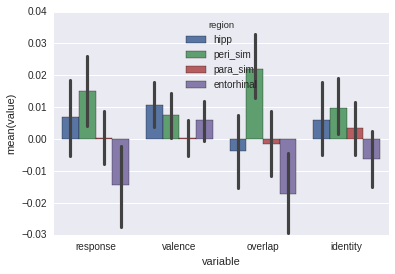

In [131]:
res_melt = pd.melt(res, id_vars=['region'], value_vars=['response','valence','overlap','identity'])
sns.barplot(x='variable',y='value',hue = 'region',data = res_melt, ci = 68)
# plt.savefig('/home/iballard/Dropbox/fd/RSA.png')

In [119]:
hipp = np.mean(all_rsas['hipp'],0) 
# hipp = hipp - np.mean(hipp)
scipy.stats.zscore(hipp)

array([[ 1.36795144, -0.44878395, -0.89156854,  0.79081803],
       [-0.92679851,  1.69580754, -0.09563068, -1.20176616],
       [-0.98622828, -0.35397899, -0.67016135, -0.7552355 ],
       [ 0.54507535, -0.89304459,  1.65736057,  1.16618363]])